In [8]:
student_id =  99101643
student_name = "Sara Rezanezhad"

print("your student id:", student_id)
print("your name:", student_name)

your student id: 99101643
your name: Sara Rezanezhad


**1) Working with arrays using PyLab**

In [18]:
from pylab import *
a = array([[1, 2, 3, 4]])
b = array( [[0, 4, 7, 6]] )
print(a*b)

[[ 0  8 21 24]]


In [62]:
import numpy as geek
a = array([[1, 2, 3, 4]])
b = array( [[0, 4, 7, 6]] )
ans = geek.multiply(a,b)
print(ans)

[[ 0  8 21 24]]


In [65]:
whos

Variable                     Type                          Data/Info
--------------------------------------------------------------------
ALLOW_THREADS                int                           1
Annotation                   type                          <class 'matplotlib.text.Annotation'>
Arrow                        type                          <class 'matplotlib.patches.Arrow'>
Artist                       type                          <class 'matplotlib.artist.Artist'>
AutoLocator                  type                          <class 'matplotlib.ticker.AutoLocator'>
Axes                         type                          <class 'matplotlib.axes._axes.Axes'>
AxisError                    type                          <class 'numpy.AxisError'>
BUFSIZE                      int                           8192
BitGenerator                 type                          <class 'numpy.random.bit_generator.BitGenerator'>
Button                       type                          <clas

**2) Defining a new function.**

In [66]:
def my_square_function(x, c):
    return   x*x + c

In [67]:
my_square_function?

Signature: my_square_function(x, c)
Docstring: <no docstring>
File:      /tmp/ipykernel_78/3890668996.py
Type:      function


In [68]:
my_square_function(5, 15)

40

**3) Loading matlab data (.mat) and plot power spectrum**

In [1]:
from scipy.io import loadmat                    
from pylab import *                            
from numpy import where
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
rcParams['figure.figsize']=(12,3)              

In [ ]:
def PSD(f, signal, Fs):
    t = 1/Fs        # Sample spacing
    T = len(signal) # Signal duration
    
    s = np.sum([signal[i] * np.exp(-1j*2*np.pi*f*i*t) for i in range(T)])
    
    return t**2 / T * np.abs(s)**2

In [ ]:
PSD?

Signature: PSD(f, signal, Fs)
Docstring: <no docstring>
File:      /tmp/ipykernel_58/1660351170.py
Type:      function


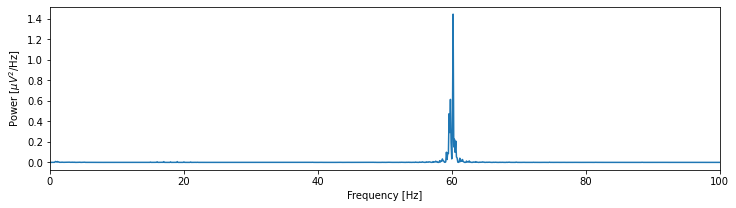

In [69]:
data = loadmat("EEG-1.mat")           # Load the EEG data
EEG = data['EEG'].reshape(-1)         # Extract the EEG variable
t = data['t'][0]                      # ... and the t variable

x = EEG                               # Relabel the data variable
dt = t[1] - t[0]                      # Define the sampling interval
N = x.shape[0]                        # Define the total number of data points
T = N * dt                            # Define the total duration of the data

xf = fft(x-x.mean())                           # Compute Fourier transform of x
Sxx =  2 * dt ** 2 / T * (xf * xf.conj())                             # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]                             # Ignore negative frequencies

df = 1 / T.max()                      # Determine frequency resolution
fNQ = 1 / dt / 2                      # Determine Nyquist frequency
faxis = arange(0,fNQ,df)              # Construct frequency axis

plot(faxis, Sxx.real)                 # Plot spectrum vs frequency
xlim([0, 100])                        # Select frequency range
xlabel('Frequency [Hz]')              # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()

#** PART II: NEURON MODELS**

## Import necessary packages 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

##################################
# add all necessary packages here
##################################


In [3]:
# @markdown Execute this code to initialize the default parameters


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
print(pars)

{'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0, 'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0, 'T': 400.0, 'dt': 0.1, 'range_t': array([0.000e+00, 1.000e-01, 2.000e-01, ..., 3.997e+02, 3.998e+02,
       3.999e+02])}


In [24]:
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0

  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration

  for it in range(Lt - 1):

    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period

    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage
      tr = tref / dt  # set refractory time

    ########################################################################
    ## TODO for students: compute the membrane potential v, spike train sp #
    # Fill out function and remove
    #raise NotImplementedError('calculate the dv/dt and the update step!')
    ########################################################################

    # Calculate the increment of the membrane potential
    dv = dt*(E_L-v[it] +(Iinj[it]/g_L))/tau_m
    # Update the membrane potential
    v[it + 1] =v[it] + dv

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


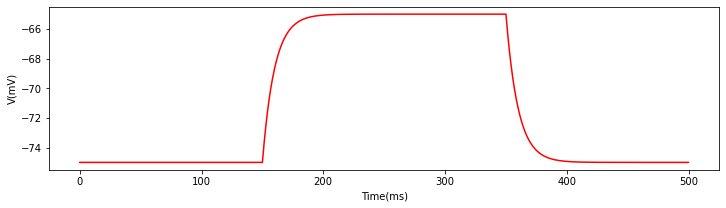

In [73]:
# Get parameters
pars = default_pars(T=500) 
#print(pars)
range_t = pars['range_t']
# Simulate LIF model
v, sp = run_LIF(pars, Iinj=100, stop=True)
#print(sp)
# Visualize
plt.plot(range_t, v, color='red')
xlabel('Time(ms)')
ylabel('V(mV)')
plt.show()

# Response of an LIF model to different types of input currents


In [ ]:
def different_DC_Currents(I_dc, tau_m):
  pars = default_pars(T=100.)
  pars['tau_m'] = tau_m
  pars['range_t']=range_t
  v, sp = run_LIF(pars, Iinj=I_dc)
  return v , sp

Enter the input current 200
Enter the time constant 10


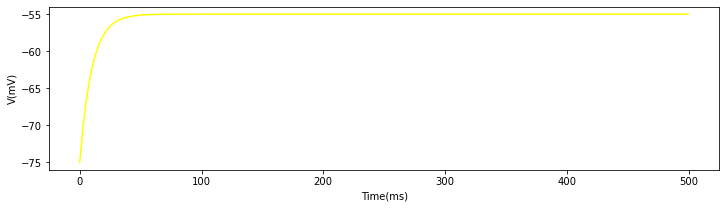

In [85]:
I_dc=int(input("Enter the input current"))
tau_m=int(input("Enter the time constant"))
v, sp =different_DC_Currents(I_dc, tau_m)
plt.plot(range_t, v, color='yellow')
xlabel('Time(ms)')
ylabel('V(mV)')
plt.show()

As we try different amounts of input currents with same time constant(tau=10),turns out around I=200pA  is needed to reach the threshold & when DC current reaches almost 210pA we cross the threshold voltage

## Gaussian white noise (GWN) current 


In [22]:
def my_GWN(pars, mu, sig, myseed=False):
  """
  Function that generates Gaussian white noise input

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()
  # Generate GWN and convert units to sec.
  I_gwn = (sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)) + mu # X=sigma*Z +mu

  return I_gwn

help(my_GWN)

Help on function my_GWN in module __main__:

my_GWN(pars, mu, sig, myseed=False)
    Function that generates Gaussian white noise input
    
    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      myseed     : random seed. int or boolean
                   the same seed will give the same
                   random number sequence
    
    Returns:
      I          : Gaussian white noise input



### Analyzing GWN Effects on Spiking


1) Fluctuations can increase voltage and bring it closer to the threshold voltage ;so we need smaller input current because a part of path for spike to reach the threshold has already been covered!

2) The standard deviation represents of dispersal of irregularity of the spikes (or we can call it noise).By increasing sigma, the more range is expanded so we observe more  irregularity of the spikes.

# F-I Explorer for different sig_gwn


In [87]:
def sigma_affect(sig_gwn):
  pars = default_pars(T=1000.)
  AveI = np.arange(100., 400., 10.)  #numpy.arange([start, ]stop, [step, ]dtype=None, *, like=None)
                                       #Return evenly spaced values within a given interval.
  SpikeCount = np.zeros(len(AveI))    #numpy.zeros(shape, dtype=float, order='C', *, like=None)
                                        #Return a new array of given shape and type, filled with zeros.
  SpikeCountDC = np.zeros(len(AveI))

  for i in range(len(AveI)):
      I_GWN = my_GWN(pars, mu=AveI[i], sig=sig_gwn, myseed=False)
      v, rec_spikes = run_LIF(pars, Iinj=I_GWN) 
      SpikeCount[i] = len(rec_spikes)
      v_dc, rec_sp_dc = run_LIF(pars, Iinj=AveI[i])
      SpikeCountDC[i] = len(rec_sp_dc)
  return SpikeCount , SpikeCountDC , AveI

Enter the input standard deviation 1


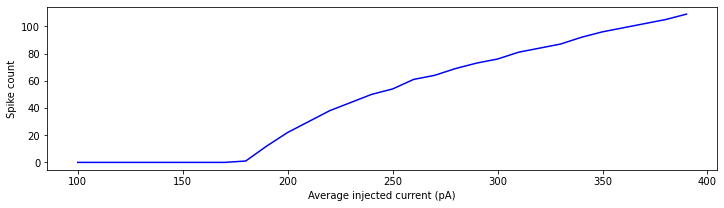

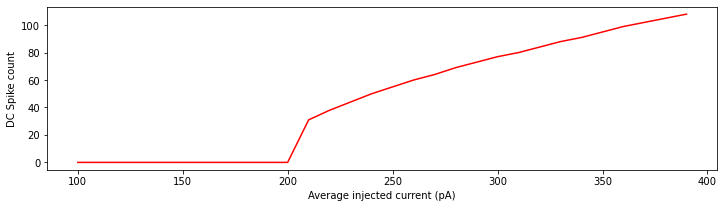

In [90]:
 sig_gwn=int(input("Enter the input standard deviation"))
SpikeCount , SpikeCountDC , AveI= sigma_affect(sig_gwn)
#print(AveI)
plt.plot(AveI, SpikeCount, color='blue')
plt.ylabel('Spike count')
plt.xlabel('Average injected current (pA)')
plt.show()
plt.plot(AveI, SpikeCountDC, color='red')
plt.ylabel('DC Spike count')
plt.xlabel('Average injected current (pA)')
plt.show()

As we've guessed in the previous part, GWN can help reach to the threshold voltage with less input current; by increasing the standard deviation of GWN the F-I curve becomes more linear but with DC input, the curve doesn't change very much.

## Compute $CV_{ISI}$ values


<function matplotlib.pyplot.show(close=None, block=None)>

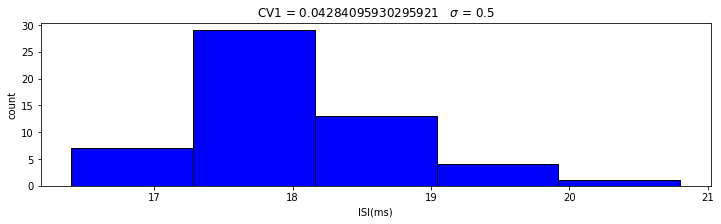

In [29]:
def isi_cv_LIF(spike_times):
  """
  Calculates the interspike intervals (isi) and
  the coefficient of variation (cv) for a given spike_train

  Args:
    spike_times : (n, ) vector with the spike times (ndarray)

  Returns:
    isi         : (n-1,) vector with the inter-spike intervals (ms)
    cv          : coefficient of variation of isi (float)

  """
  
  if len(spike_times) >= 2:
    # Compute isi
    isi =np.diff(spike_times)                 #np.diff: Calculate the n-th discrete difference along the given axis.        
    # Compute cv
    cv = isi.std()/isi.mean()
  else:
    isi = np.nan
    cv = np.nan

  return isi, cv


# Set parameters
pars = default_pars(T=1000.)
mu_gwn = 250
sig_gwn1 = 0.5
sig_gwn2 = 3.0

# Run LIF model for sigma = 0.5
I_GWN1 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn1, myseed=2020)
_, sp1 = run_LIF(pars, Iinj=I_GWN1)

# Run LIF model for sigma = 3
I_GWN2 = my_GWN(pars, mu=mu_gwn, sig=sig_gwn2, myseed=2020)
_, sp2 = run_LIF(pars, Iinj=I_GWN2)

# Compute ISIs/CV
isi1, cv1 = isi_cv_LIF(sp1)
isi2, cv2 = isi_cv_LIF(sp2)
#print(isi1, cv1) 
# Visualize
plt.hist(isi1,color = 'blue', edgecolor = 'black',bins = 5)
plt.title('CV1 = '+str(cv1)+'   $\sigma$ = '+str(sig_gwn1))
plt.ylabel('count')
plt.xlabel('ISI(ms)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

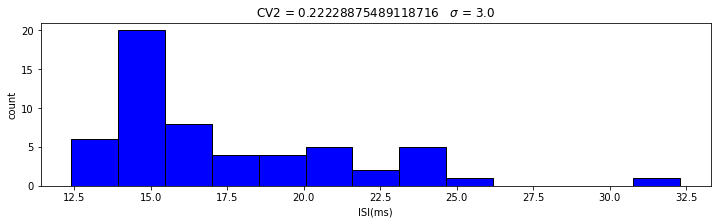

In [30]:
plt.hist(isi2,color = 'blue', edgecolor = 'black',bins = 13)
plt.title('CV2 = '+str(cv2)+'   $\sigma$ = '+str(sig_gwn2))
plt.ylabel('count')
plt.xlabel('ISI(ms)')
plt.show

## Spike irregularity explorer for different `sig_gwn`


1)As we can see in "F-I Explorer for different sig_gwn" part, with DC current we have a strong non-linear F-I curve, but as we increase $\sigma$, it helps the curve becomes more linear. 

2)We can change the mu in the last part and observe the affects;as we can see sometimes input mean voltage is higher than threshold voltage , so the only function a neuron can do is to reach the threshold then rest.  
We can answer this question in different way; according to the below formula:
\begin{equation}
\text{CV}_{\text{ISI}} = \frac{std(\text{ISI})}{mean(\text{ISI})}
\end{equation}
mean parameter has indirect relation with CV, in result as mean increase,less CV become.

3)CV is a constant parameter that just depends on two parameter in the previous part formula, and basically it depends directly on ISI which is the time between two spikes and it doesn't relate to any kind of physical quantity except time!   

## Ornstein-Uhlenbeck Process

In [32]:
def my_OU(pars, mu, sig, myseed=False):
  """
  Function that produces Ornstein-Uhlenbeck input

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

  Returns:
    I_ou       : Ornstein-Uhlenbeck input current
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou']  # [ms]

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # Initialize
  noise = np.random.randn(Lt)
  I_ou = np.zeros(Lt)
  I_ou[0] = noise[0] * sig

  # generate OU
  for it in range(Lt-1):
    I_ou[it+1] =  (dt / tau_ou) * (mu - I_ou[it]) + np.sqrt(2 * dt / tau_ou) * sig * noise[it + 1]+I_ou[it]

  return I_ou


help(my_OU)

Help on function my_OU in module __main__:

my_OU(pars, mu, sig, myseed=False)
    Function that produces Ornstein-Uhlenbeck input
    
    Args:
      pars       : parameter dictionary
      sig        : noise amplitute
      myseed     : random seed. int or boolean
    
    Returns:
      I_ou       : Ornstein-Uhlenbeck input current



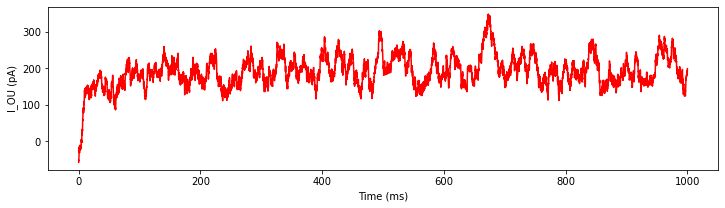

In [35]:
 pars = default_pars(T=1000.)
 pars['tau_ou'] = tau_ou=10  # [ms]
 pars['mu_ou'] = mu_ou=200
 pars['sig_ou'] = sig_ou=40

 I_ou = my_OU(pars, mu_ou, sig_ou)

 v, sp = run_LIF(pars, Iinj=I_ou)
  
 plt.plot(pars['range_t'], I_ou, 'RED')
 plt.xlabel('Time (ms)')
 plt.ylabel('I_OU (pA)')
 plt.show()


We can see as we increase time constant firing rate decrease as we expected, and spikes become more regular;so  there's less range of color noise in the plot.
It also makes CV constant smaller.

##The Hodgkin-Huxley model

In [44]:
import numpy as np
import math

In [36]:
def alphaM(V):
    return (2.5-0.1*(V+65)) / (np.exp(2.5-0.1*(V+65)) -1)

def betaM(V):
    return 4*np.exp(-(V+65)/18)

def alphaH(V):
    return 0.07*np.exp(-(V+65)/20)

def betaH(V):
    return 1/(np.exp(3.0-0.1*(V+65))+1)

def alphaN(V):
    return (0.1-0.01*(V+65)) / (np.exp(1-0.1*(V+65)) -1)

def betaN(V):
    return 0.125*np.exp(-(V+65)/80)

def HH(I0,T0):
    dt = 0.01;
    T  = math.ceil(T0/dt)  # [ms]
    gNa0 = 120   # [mS/cm^2]
    ENa  = 115;  # [mV]
    gK0  = 36;   # [mS/cm^2]
    EK   = -12;  # [mV]
    gL0  = 0.3;  # [mS/cm^2]
    EL   = 10.6; # [mV]

    t = np.arange(0,T)*dt
    V = np.zeros([T,1])
    m = np.zeros([T,1])
    h = np.zeros([T,1])
    n = np.zeros([T,1])

    V[0]=-70.0
    m[0]=0.05
    h[0]=0.54
    n[0]=0.34

    for i in range(0,T-1):
        V[i+1] = V[i] + dt*(gNa0*m[i]**3*h[i]*(ENa-(V[i]+65)) + gK0*n[i]**4*(EK-(V[i]+65)) + gL0*(EL-(V[i]+65)) + I0)
        m[i+1] = m[i] + dt*(alphaM(V[i])*(1-m[i]) - betaM(V[i])*m[i]) 
        h[i+1] = h[i] + dt*(alphaH(V[i])*(1-h[i]) - betaH(V[i])*h[i])
        n[i+1] = n[i] + dt*(alphaN(V[i])*(1-n[i]) - betaN(V[i])*n[i])


        
    return V,m,h,n,t

In [42]:
def DrawPlot(t, variable, Name):
 plt.plot(t, variable, 'blue')
 plt.xlabel('Time (ms)')
 plt.ylabel(Name)
 plt.show()

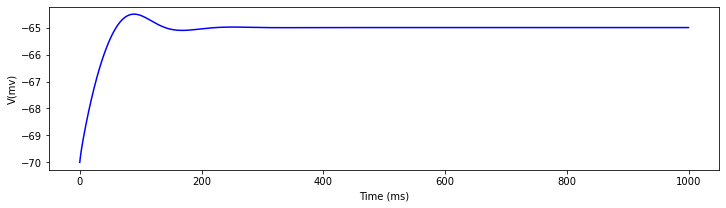

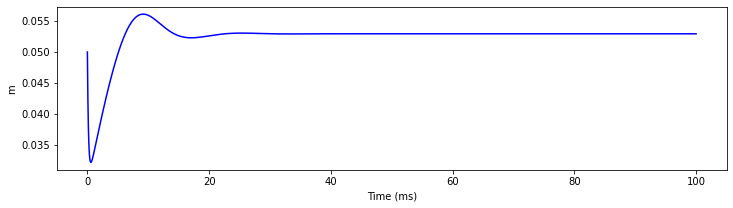

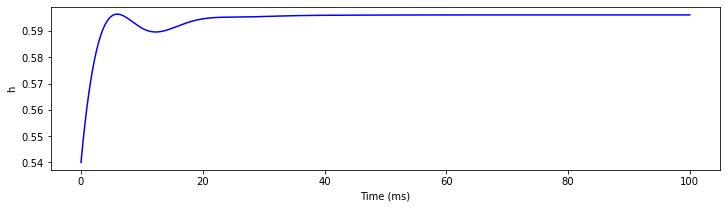

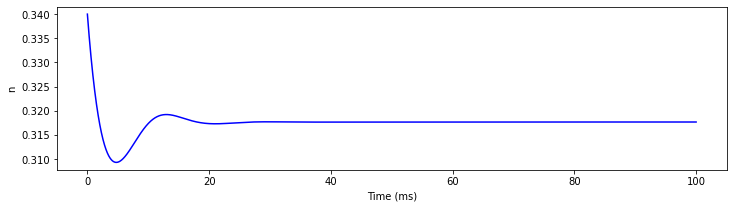

In [43]:
I0 = 0
T0 = 100
pars = default_pars(T=1000) 
#print(pars)
range_t = pars['range_t']
[V,m,h,n,t]=HH(I0,T0)
#print(V,m,h,n,t)
DrawPlot(range_t, V, 'V(mv)')
DrawPlot(t, m, 'm')
DrawPlot(t, h, 'h')
DrawPlot(t, n, 'n')